## Special Moves of SFII
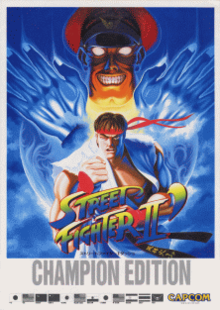

### YOLO
YOLOv3-320

### Image
Input Image : 930 x 672
Output Image : 320 x 320

In [1]:
import os

os.add_dll_directory('c:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.1/bin')
os.add_dll_directory('d:/MachineLearning/movesSF2')

<AddedDllDirectory('d:/MachineLearning/movesSF2')>

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

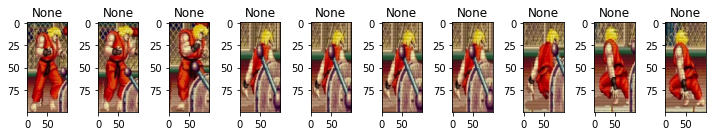

In [3]:
# Load data (deserialize)
with open('movesKen.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)


# Spliting into training, dev and test set using indexing
dataset_x = unserialized_data['dataset_x']
dataset_y = unserialized_data['dataset_y']
num_classes = np.unique(dataset_y).shape[0]
indexes = np.arange(dataset_x.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset_x.shape[0])]
test_index  = indexes[int(0.9 * dataset_x.shape[0]) :]
train_x = dataset_x[train_index]
train_y = dataset_y[train_index]
test_x  = dataset_x[test_index]
test_y  = dataset_y[test_index]


# Get moves of name from indexing
def movesName(class_index):
    if   class_index == 0: return 'None'
    elif class_index == 1: return 'Hadoken'
    elif class_index == 2: return 'Shoryuken'
    elif class_index == 3: return 'Tatsumaki Senpuu Kyaku'


# Displaying random choice of dataset
plt.figure(figsize = (10,2))
choice = np.random.choice(dataset_x.shape[0])
for i in range(dataset_x.shape[1]):
    img = dataset_x[choice][i]
    plt.subplot(1,dataset_x.shape[1],i+1)
    plt.gca().set_title(movesName(dataset_y[choice][i]))
    plt.imshow(img,  aspect='auto')
plt.tight_layout()
plt.show()

In [4]:
print("train_x", train_x.shape, len(train_x))
print("train_y", train_y.shape, len(train_y))
print("test_x", test_x.shape, len(test_x))
print("test_y", test_y.shape, len(test_y))
print("num_classes", num_classes)

train_x (1196, 10, 100, 100, 3) 1196
train_y (1196, 10, 1) 1196
test_x (133, 10, 100, 100, 3) 133
test_y (133, 10, 1) 133
num_classes 4


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, ConvLSTM2D, MaxPooling3D, BatchNormalization

In [6]:
print(tf.__file__)
print("Tensorflow:", tf.__version__)

c:\users\lycob\appdata\local\programs\python\python38\lib\site-packages\tensorflow\__init__.py
Tensorflow: 2.2.0


In [7]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, num_classes)
test_y  = keras.utils.to_categorical(test_y,  num_classes)
print(train_y.shape)
print(test_y.shape)

(1196, 10, 4)
(133, 10, 4)


In [8]:
model = Sequential()

# VGG Stack 1
model.add(ConvLSTM2D(
    filters=64, 
    kernel_size=(3, 3), 
    input_shape=(train_x.shape[1], 
                 train_x.shape[2], 
                 train_x.shape[3], 
                 train_x.shape[4]),
    padding="valid", 
    return_sequences=True, 
    activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))


# VGG Stack 2
model.add(ConvLSTM2D(
    filters=128, 
    kernel_size=(3, 3), 
    padding="valid", 
    return_sequences=True, 
    activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))


# VGG Stack 3
model.add(ConvLSTM2D(
    filters=64, 
    kernel_size=(3, 3), 
    padding="valid", 
    return_sequences=True, 
    activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))


# extract features and dropout 
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# model.add(layers.TimeDistributed(Dense(1)))
# model.add(layers.Flatten())
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()
# model.add(layers.Flatten())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 98, 98, 64)    154624    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 98, 98, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 47, 47, 128)   885248    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 47, 47, 128)   512       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 23, 23, 128)   0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 21, 21, 64)    4

In [9]:
model.output_shape

(None, 10, 4)

In [10]:
model.compile(
    loss=keras.losses.categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['acc'],    
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 1

# Fit the model to the training data.
model.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
1196/1196 [==============================] - 881s 736ms/step - loss: 1.2806 - acc: 0.7010 - val_loss: 0.9318 - val_acc: 0.7451 - lr: 0.0010
Epoch 2/20
1196/1196 [==============================] - 884s 739ms/step - loss: 0.6893 - acc: 0.7727 - val_loss: 0.7461 - val_acc: 0.7880 - lr: 0.0010
Epoch 3/20
1196/1196 [==============================] - 882s 737ms/step - loss: 0.6077 - acc: 0.7904 - val_loss: 0.6356 - val_acc: 0.7895 - lr: 0.0010
Epoch 4/20
1196/1196 [==============================] - 881s 736ms/step - loss: 0.7113 - acc: 0.7695 - val_loss: 0.8536 - val_acc: 0.6835 - lr: 0.0010
Epoch 5/20
1196/1196 [==============================] - 881s 737ms/step - loss: 0.6491 - acc: 0.7740 - val_loss: 0.6843 - val_acc: 0.7414 - lr: 0.0010
Epoch 6/20
1196/1196 [==============================] - 881s 737ms/step - loss: 0.5860 - acc: 0.7936 - val_loss: 0.5515 - val_acc: 0.8316 - lr: 0.0010
Epoch 7/20
1196/1196 [==============================] - 881s 737ms/step - loss: 0.5575 - acc: 

In [ ]:
score = model.evaluate(test_x, test_y, batchverbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])